In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr, chi2_contingency
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score,precision_score, classification_report, confusion_matrix
from imblearn.metrics import specificity_score
from matplotlib.ticker import FixedLocator
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
warnings.simplefilter(action='ignore')

Wczytanie danych

In [75]:
r_wine = pd.read_csv('data/winequality-red.csv', sep=';')
r_wine['type'] = 'red'
w_wine = pd.read_csv('data/winequality-white.csv', sep=';')
w_wine['type'] = 'white'

In [76]:
r_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [77]:
w_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


In [78]:
data = pd.concat([r_wine, w_wine], ignore_index=True)
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


OPIS I WSTEPNA ANALIZA DANYCH

In [79]:
data['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

Rozklad zmiennej objasnianej quality

Text(0, 0.5, 'Liczba wystąpień')

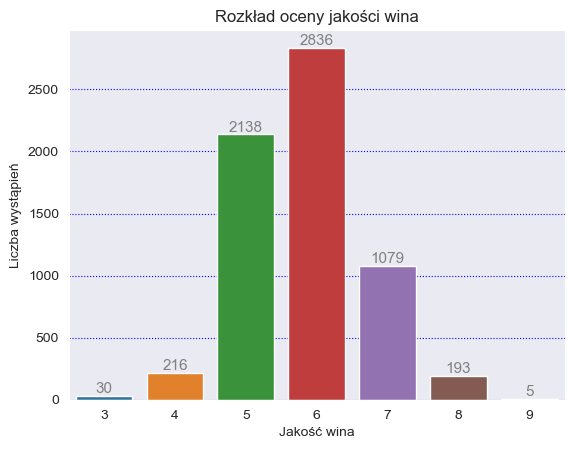

In [80]:
ax = sns.countplot(x='quality', data=data)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 5),
                textcoords='offset points')

ax.set_title('Rozkład oceny jakości wina')
ax.set_xlabel('Jakość wina')
ax.set_ylabel('Liczba wystąpień')

Rozkład zmiennej quality ze wzgledu na kolor wina

Text(0, 0.5, 'Liczba wystąpień')

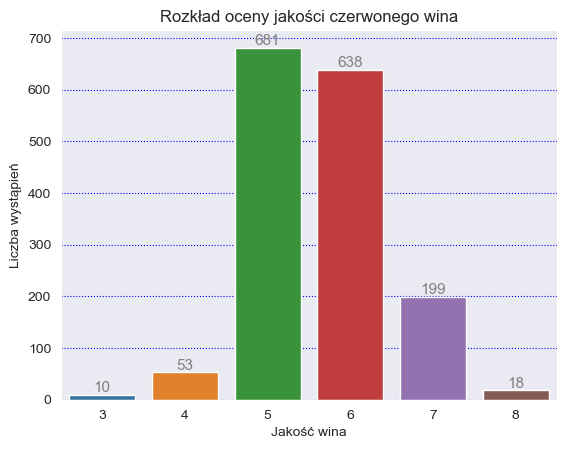

In [81]:
ax = sns.countplot(x='quality', data=data[data['type'] == 'red'])

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 5),
                textcoords='offset points')

ax.set_title('Rozkład oceny jakości czerwonego wina')
ax.set_xlabel('Jakość wina')
ax.set_ylabel('Liczba wystąpień')

Text(0, 0.5, 'Liczba wystąpień')

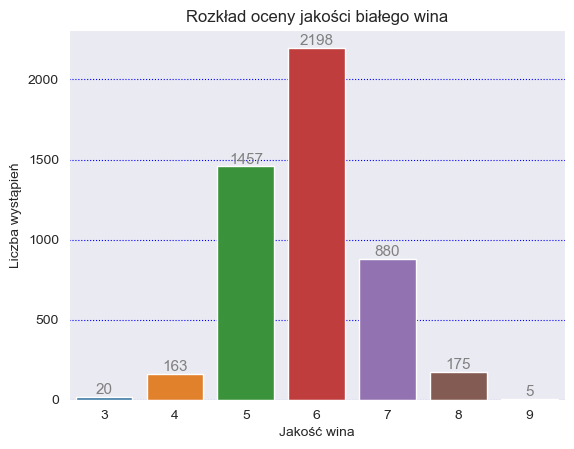

In [82]:
ax = sns.countplot(x='quality', data=data[data['type'] == 'white'])

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 5),
                textcoords='offset points')

ax.set_title('Rozkład oceny jakości białego wina')
ax.set_xlabel('Jakość wina')
ax.set_ylabel('Liczba wystąpień')

Rozklad zmiennej type odpowiadajacej za kolor wina

In [83]:
data['type'].value_counts()

type
white    4898
red      1599
Name: count, dtype: int64

<Axes: xlabel='type', ylabel='count'>

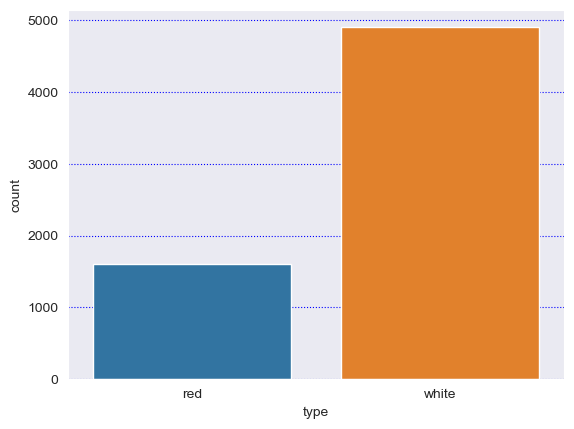

In [84]:
sns.countplot(x='type', data=data)

Typy danych w zbiorze

In [85]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
type                     object
dtype: object

Rozmiar danych

In [86]:
data.shape

(6497, 13)

Statystyki opisowe dla zmiennych liczbowych

In [87]:
data_float_column = data.select_dtypes(include=[float]).columns
data[data_float_column].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


PRZYGOTOWANIE DANYCH

Zamiana zmiennej quality na zmienna zero-jedynkowa:
 - quality od 3 do 6 -> 0 
 - quality od 7 do 9 -> 1

In [88]:
data['quality'] = data['quality'].apply(lambda q: 0 if q < 7 else 1)
data['quality'].value_counts()

quality
0    5220
1    1277
Name: count, dtype: int64

Text(0, 0.5, 'Liczba wystąpień')

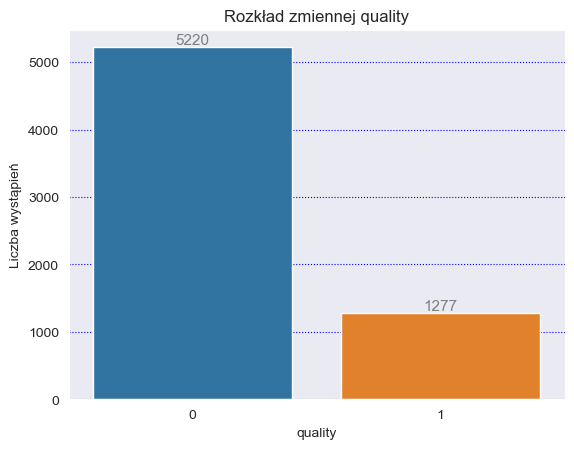

In [89]:
ax = sns.countplot(x='quality', data=data)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 5),
                textcoords='offset points')

ax.set_title('Rozkład zmiennej quality')
ax.set_xlabel('quality')
ax.set_ylabel('Liczba wystąpień')

Zamiana zmiennej type na zmienna zero-jedynkowa type red -> 0 type white -> 1

In [90]:
data['type'] = data['type'].apply(lambda t: 0 if t == 'red' else 1)
data['type']. value_counts()

type
1    4898
0    1599
Name: count, dtype: int64

Wartosci brakujace

In [91]:
data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

Sprawdzenie wartosci odstajacych

In [92]:
def outliers(x, y, column, color):
    sns.boxplot(ax=axs[x][y], y=data[column], color=color)
    axs[x][y].set_title(column)
    

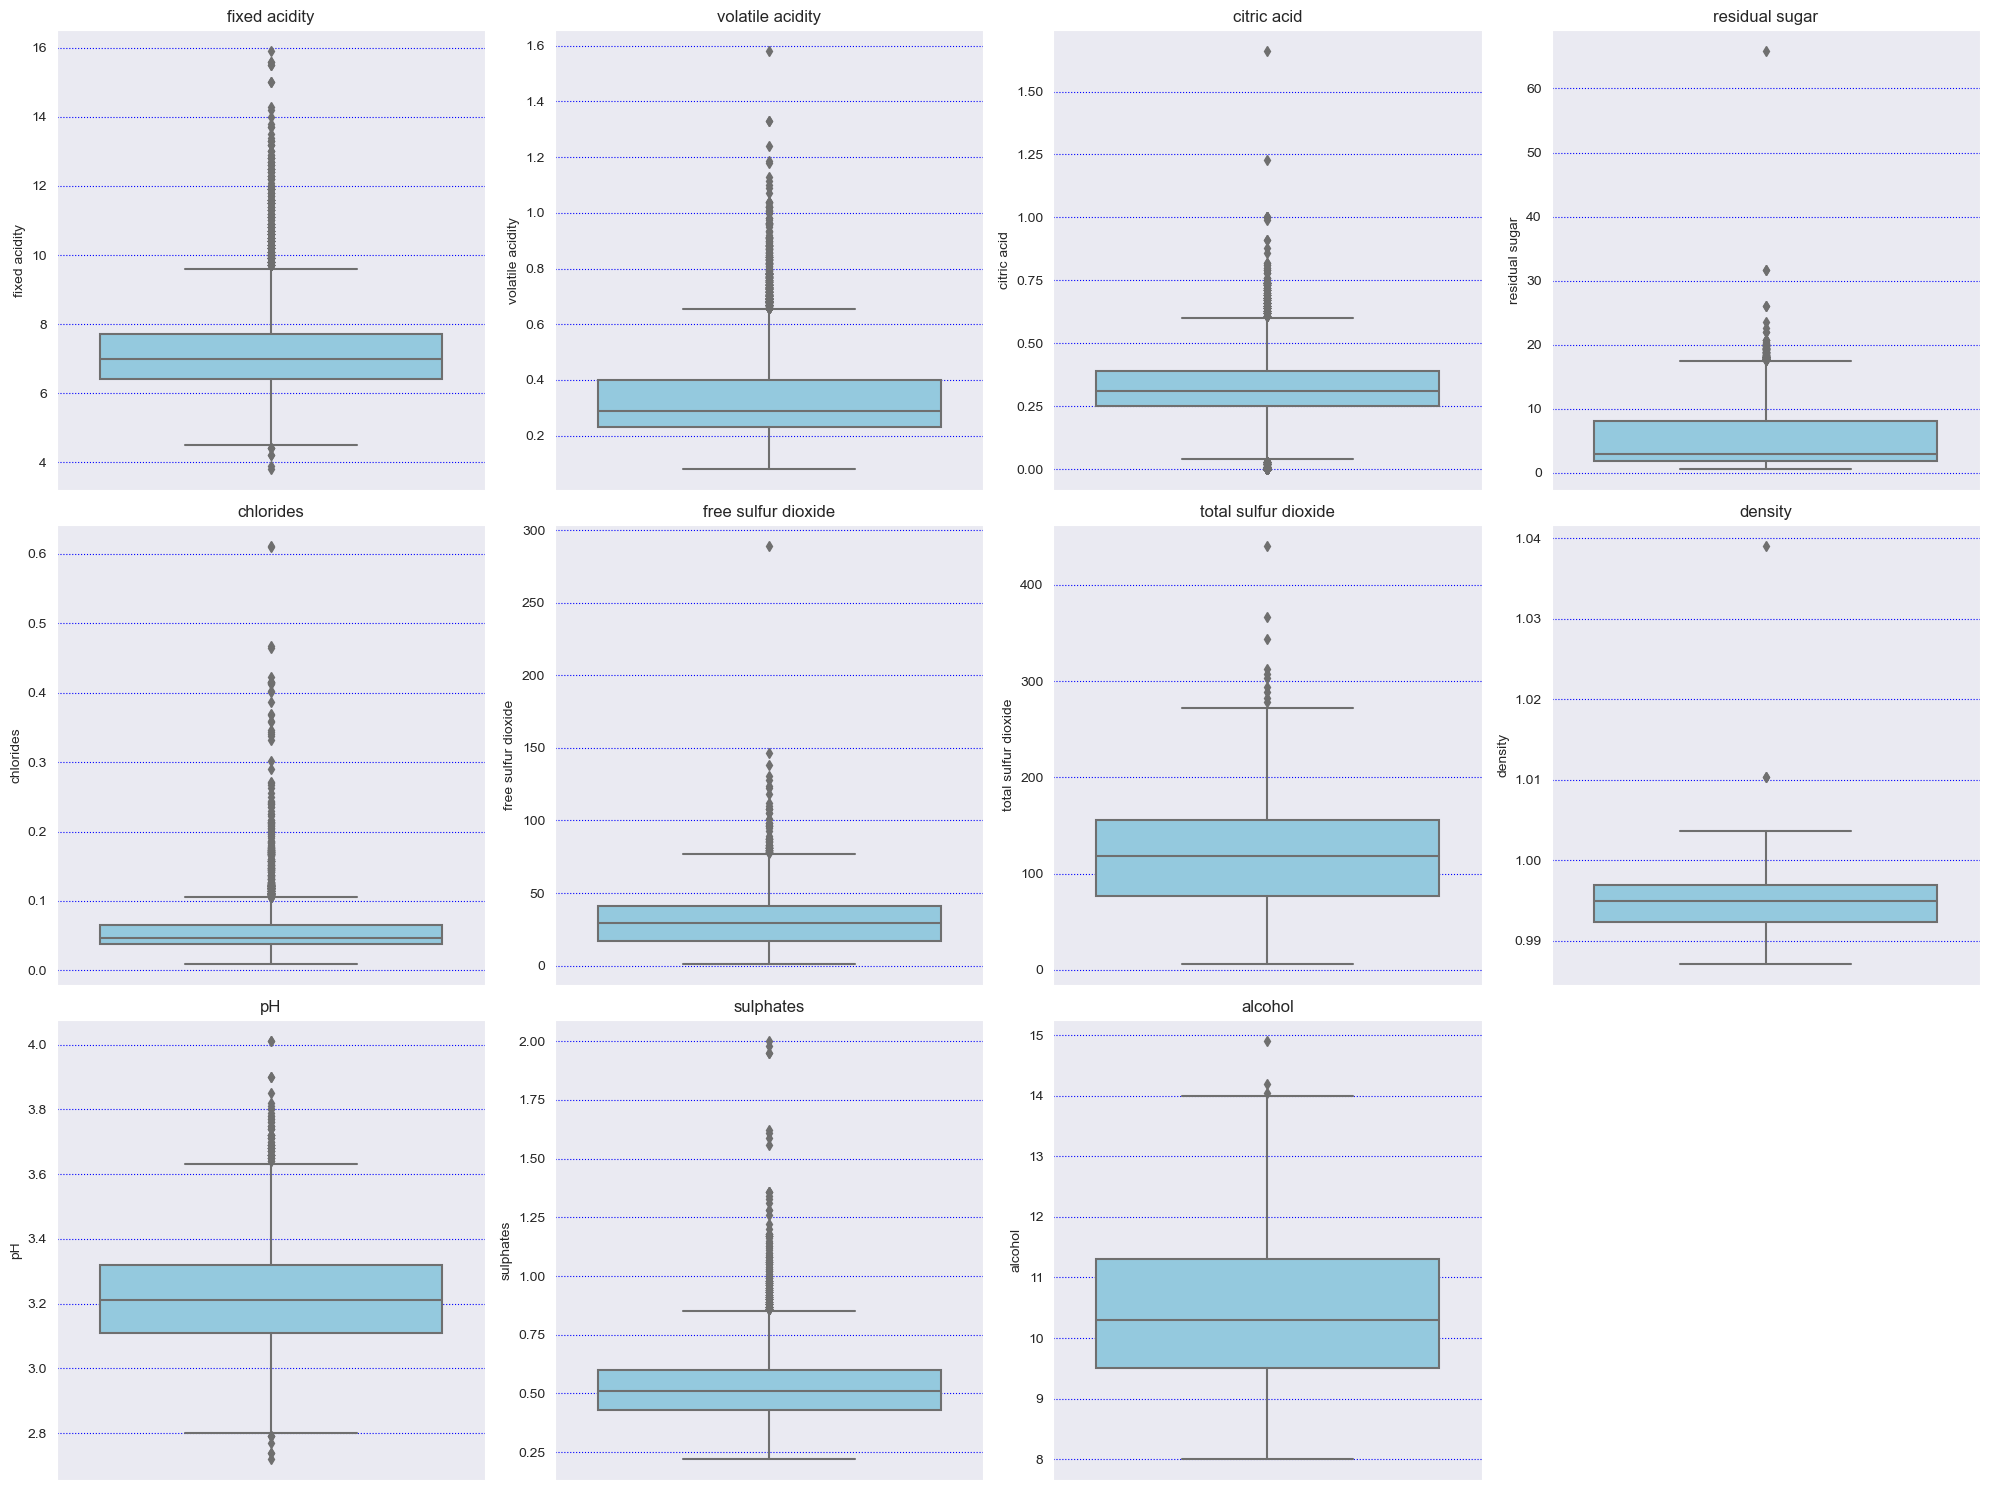

In [93]:
fig, axs = plt.subplots(ncols=4, nrows = 3, figsize=(20,15))
color = 'skyblue'
outliers(0,0, 'fixed acidity', color)
outliers(0,1, 'volatile acidity', color)
outliers(0,2, 'citric acid', color)
outliers(0,3, 'residual sugar', color)
outliers(1,0, 'chlorides', color)
outliers(1,1, 'free sulfur dioxide', color)
outliers(1,2, 'total sulfur dioxide', color)
outliers(1,3, 'density', color)
outliers(2,0, 'pH', color)
outliers(2,1, 'sulphates', color)
outliers(2,2, 'alcohol', color)
fig.delaxes(axs[2][3])
sns.set_style("darkgrid", {"grid.color": "blue", "grid.linestyle": ":"})
plt.tight_layout()
plt.show()

Analiza Wpływu Zmiennych na Zmienną Prognozowaną (Y)


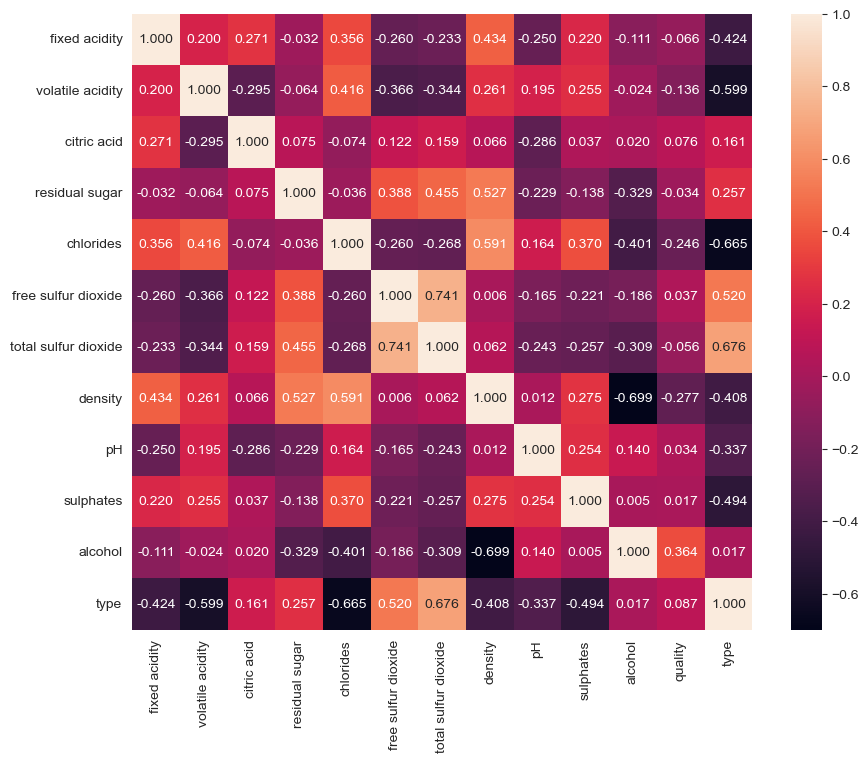

In [94]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(method='spearman').drop('quality'), annot=True, fmt='.3f')
plt.show()

Analiza Wpływu Zmiennych na Zmienną Prognozowaną (Y)

In [95]:
spearman_correlations_pvalues = {
    column: spearmanr(data[column], data['quality']) 
    for column in data.columns if column not in ['quality', 'type']
}

data_table = {
    "Zmienna": [],
    "Korelacja Spearmana": [],
    "p_value": []
}

for column, (correlation, p_value) in spearman_correlations_pvalues.items():
    data_table["Zmienna"].append(column)
    data_table["Korelacja Spearmana"].append(correlation)
    data_table["p_value"].append(p_value)

results_df = pd.DataFrame(data_table)

results_df.round(3)

,Zmienna,Korelacja Spearmana,p_value
0,fixed acidity,-0.066,0.000
1,volatile acidity,-0.136,0.000
2,citric acid,0.076,0.000
3,residual sugar,-0.034,0.007
4,chlorides,-0.246,0.000
5,free sulfur dioxide,0.037,0.003
6,total sulfur dioxide,-0.056,0.000
7,density,-0.277,0.000
8,pH,0.034,0.006
9,sulphates,0.017,0.167


Badanie wplywu koloru wina na zmienna quality

In [96]:
contingency_table = pd.crosstab(data['type'], data['quality'])

# Obliczenie testu chi-kwadrat
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Obliczenie współczynnika Phi
phi = (chi2 / len(data))**0.5

print(f'Współczynnik Phi: {phi:.3f}, p_value: {p:.3f}')

Współczynnik Phi: 0.087, p_value: 0.000


PODZIAL DANYCH NA ZBIOR UCZACY I TESTOWY


In [97]:
X = data.drop('quality', axis=1)
y = data['quality']

In [98]:
# podzial na zbior testowy i treningowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Statystyki opisowe dla zbiorow

In [99]:
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
count,5197.000000,5197.00000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000
mean,7.203146,0.33722,0.320275,5.471666,0.055824,30.565326,115.713392,0.994691,3.216956,0.531024,10.483601,0.757937
std,1.288267,0.16218,0.144684,4.796583,0.034830,17.439545,56.141996,0.003009,0.159628,0.148661,1.191374,0.428373
min,3.800000,0.08000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000,0.000000
25%,6.400000,0.23000,0.250000,1.800000,0.038000,17.000000,78.000000,0.992340,3.110000,0.430000,9.500000,1.000000
50%,7.000000,0.29000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994900,3.210000,0.510000,10.300000,1.000000
75%,7.700000,0.40000,0.390000,8.200000,0.064000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,1.000000
max,15.600000,1.58000,1.230000,65.800000,0.611000,146.500000,344.000000,1.038980,4.010000,2.000000,14.200000,1.000000


In [100]:
X_test.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,7.263923,0.349446,0.312069,5.329577,0.056872,30.365385,115.869231,0.994720,3.224677,0.532246,10.524579,0.737692
std,1.327972,0.173832,0.147699,4.599556,0.035839,18.943749,58.037446,0.002959,0.165259,0.149438,1.197945,0.440058
min,4.400000,0.080000,0.000000,0.700000,0.016000,1.000000,8.000000,0.987580,2.720000,0.230000,8.400000,0.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,17.000000,74.000000,0.992300,3.110000,0.430000,9.500000,0.000000
50%,7.000000,0.300000,0.300000,2.900000,0.047000,28.000000,119.000000,0.994805,3.210000,0.505000,10.400000,1.000000
75%,7.800000,0.420000,0.390000,7.800000,0.066000,41.000000,155.000000,0.996993,3.330000,0.600000,11.400000,1.000000
max,15.900000,1.240000,1.660000,26.050000,0.415000,289.000000,440.000000,1.003150,4.010000,1.950000,14.900000,1.000000


In [101]:
print(y_train.value_counts())

quality
0    4172
1    1025
Name: count, dtype: int64


Balansowanie zbioru treningowego danych -  oversampling

In [102]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [103]:
print(y_train.value_counts())

quality
0    4172
1    4172
Name: count, dtype: int64


Statystyki opisowe po oversamplingu

In [104]:
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
count,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000,8344.000000
mean,7.150328,0.318214,0.326431,5.207138,0.051384,30.829249,113.637011,0.994034,3.218915,0.534074,10.838281,0.782958
std,1.267798,0.144219,0.127815,4.510519,0.030201,16.559316,52.873044,0.003072,0.151438,0.146118,1.244519,0.412256
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000,0.000000
25%,6.400000,0.220000,0.270000,1.838436,0.035563,18.000000,84.000000,0.991480,3.120000,0.430000,9.733211,1.000000
50%,6.900000,0.280000,0.319292,3.000000,0.044000,29.373918,116.000000,0.993800,3.210702,0.510000,10.900000,1.000000
75%,7.504835,0.370000,0.387339,7.600000,0.057000,41.000000,149.000000,0.996458,3.319249,0.610000,11.838757,1.000000
max,15.600000,1.580000,1.230000,65.800000,0.611000,146.500000,344.000000,1.038980,4.010000,2.000000,14.200000,1.000000


Przydatne funkcje 

In [105]:
def measures_score(y_true, y_pred, to_print=True, set_name='', to_return=False):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    spec = specificity_score(y_true, y_pred)
    
    if to_print:
        print(f'{set_name: <5} accuracy= {round(acc, 3): <10} recall= {round(rec, 3): <12} specificity= {round(spec, 3): <15}')
        
    if to_return:
        return acc, rec, spec

In [106]:
def subplot_measures(axs, a_x, x_values, y_test_val, y_train_val, x_label, y_label, title, display_value):
    axs[a_x].plot(x_values, y_test_val, label='testowy')
    axs[a_x].plot(x_values, y_train_val, color='r', label='treningowy')
    axs[a_x].set_title(title)
    axs[a_x].set_xlabel(x_label)
    axs[a_x].set_ylabel(y_label)
    axs[a_x].legend()   
    axs[a_x].xaxis.set_major_locator(FixedLocator(display_value))
    axs[a_x].set_ylim([0.2, 1.01])

In [107]:
def standardize_data(x_data):
    # wykluczenie zmiennej bianarnej 
    x_data = x_data.reset_index(drop=True)
    x_data_continuous = x_data.drop('type', axis=1)
    
    # standaryzacja 
    scaler = StandardScaler()
    x_data_continuous_scaled = scaler.fit_transform(x_data_continuous)
    x_data_continuous_scaled = pd.DataFrame(x_data_continuous_scaled, columns=x_data_continuous.columns)
    
    return pd.concat([x_data_continuous_scaled, x_data['type']], axis=1)

-----------------------------Algorytm SVM-------------------------

In [108]:
# dane do algorytmu SVM
X_train_svm = X_train.copy()
y_train_svm = y_train.copy()
X_test_svm = X_test.copy()
y_test_svm = y_test.copy()

Standaryzacja zmiennych 

In [109]:
X_train_svm = standardize_data(X_train_svm)
X_test_svm = standardize_data(X_test_svm)

Tworzenie modelu SVM z domyslnymi parametrami 

In [110]:
model = svm.SVC(kernel='rbf', random_state=42)
model.fit(X_train_svm, y_train_svm)

y_pred_train = model.predict(X_train_svm)
measures_score(y_train_svm, y_pred_train, set_name='TRAIN')

y_pred_test = model.predict(X_test_svm)
measures_score(y_test_svm, y_pred_test, set_name='TEST')

TRAIN accuracy= 0.837      recall= 0.906        specificity= 0.769          
TEST  accuracy= 0.71       recall= 0.925        specificity= 0.658          


Badanie wpływu zwiększania parametru C

Parametr c w zakresie 1-101

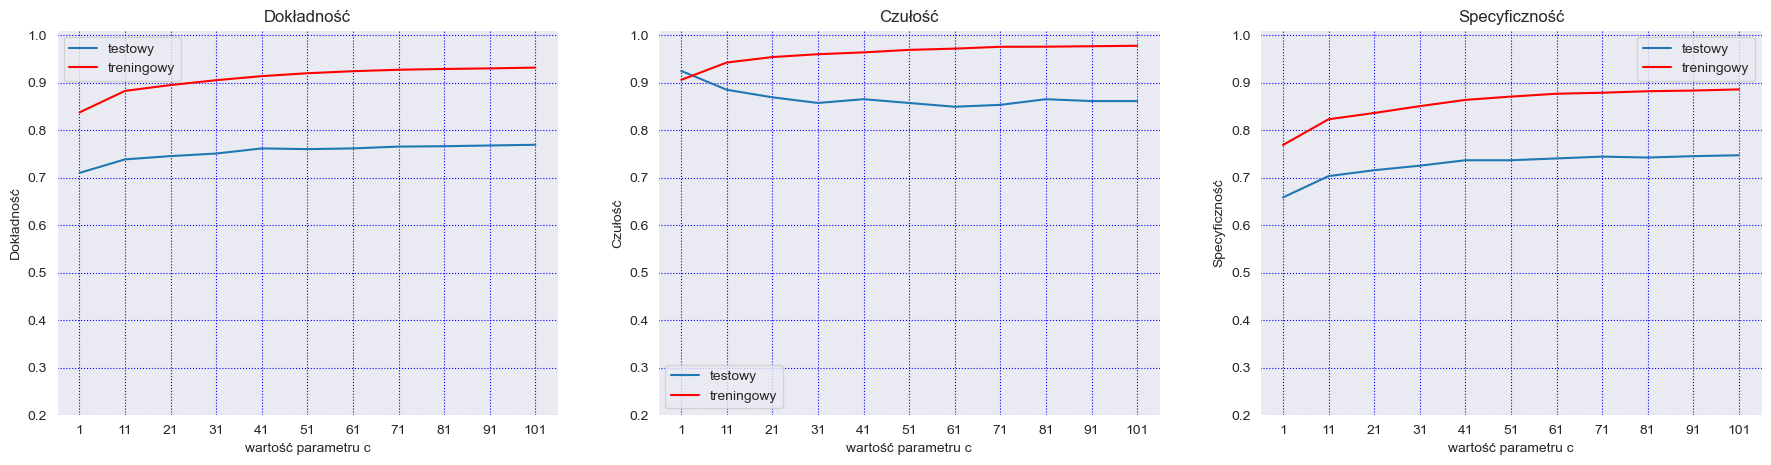

In [111]:
test_measures_svm = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_svm = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
c_range =range(1, 110, 10)

for c in c_range:
    model = svm.SVC(C=c, random_state=42)
    model.fit(X_train_svm, y_train_svm)

    # Ocena na zbiorze testowym
    y_pred_test_svm = model.predict(X_test_svm)
    measures_scores_test_svm = measures_score(y_test_svm, y_pred_test_svm, to_return=True, to_print=False)
    test_measures_svm['accuracy'].append(measures_scores_test_svm[0])
    test_measures_svm['recall'].append(measures_scores_test_svm[1])
    test_measures_svm['specificity'].append(measures_scores_test_svm[2])

    # Ocena na zbiorze treningowym
    y_pred_train_svm = model.predict(X_train_svm)
    measures_scores_train_svm = measures_score(y_train_svm, y_pred_train_svm, to_return=True, to_print=False)
    train_measures_svm['accuracy'].append(measures_scores_train_svm[0])
    train_measures_svm['recall'].append(measures_scores_train_svm[1])
    train_measures_svm['specificity'].append(measures_scores_train_svm[2])

fig, axs = plt.subplots(1, 3, figsize=(22, 5))
c_range_to_display =  range(1, 110, 10)

subplot_measures(axs, 0, c_range, test_measures_svm['accuracy'], train_measures_svm['accuracy'], 'wartość parametru c', 'Dokładność', 'Dokładność', c_range_to_display)
subplot_measures(axs, 1, c_range, test_measures_svm['recall'], train_measures_svm['recall'], 'wartość parametru c', 'Czułość', 'Czułość', c_range_to_display)
subplot_measures(axs, 2, c_range, test_measures_svm['specificity'], train_measures_svm['specificity'], 'wartość parametru c', 'Specyficzność', 'Specyficzność', c_range_to_display)

Parametr C w zakresie 0.01 - 1

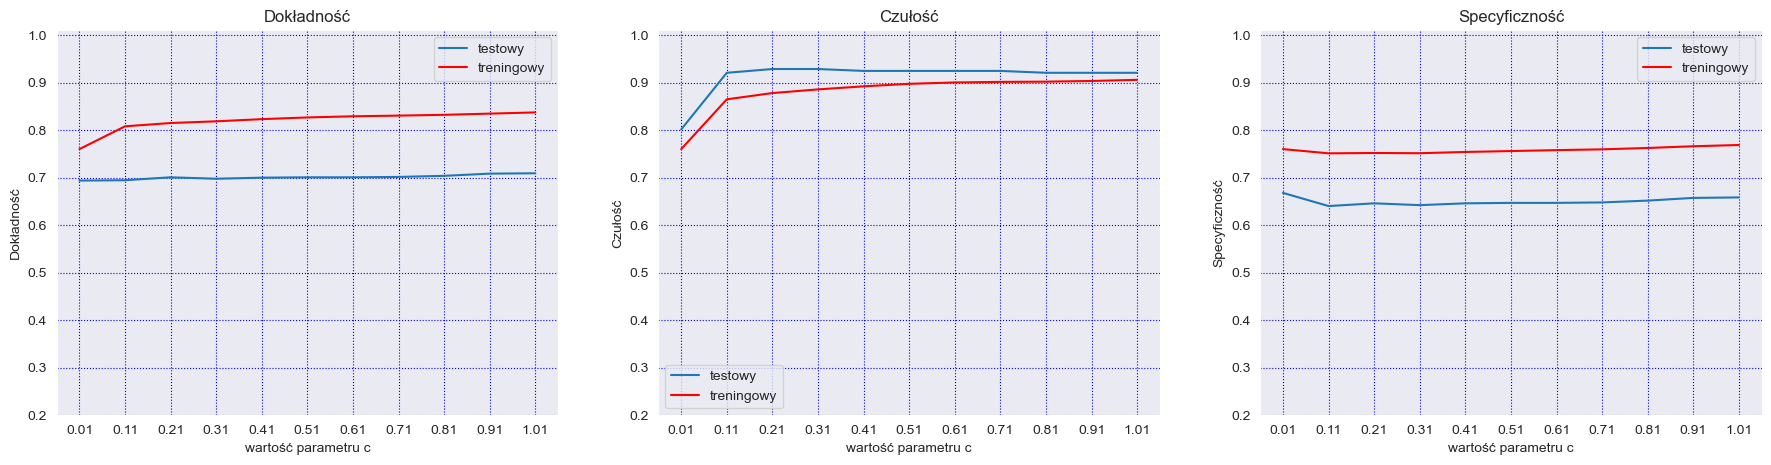

In [112]:
test_measures_svm = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_svm = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
c_range = np.arange(0.01, 1.1, 0.1)

for c in c_range:
    model = svm.SVC(C=c, random_state=42)
    model.fit(X_train_svm, y_train_svm)

    # Ocena na zbiorze testowym
    y_pred_test_svm = model.predict(X_test_svm)
    measures_scores_test_svm = measures_score(y_test_svm, y_pred_test_svm, to_return=True, to_print=False)
    test_measures_svm['accuracy'].append(measures_scores_test_svm[0])
    test_measures_svm['recall'].append(measures_scores_test_svm[1])
    test_measures_svm['specificity'].append(measures_scores_test_svm[2])

    # Ocena na zbiorze treningowym
    y_pred_train_svm = model.predict(X_train_svm)
    measures_scores_train_svm = measures_score(y_train_svm, y_pred_train_svm, to_return=True, to_print=False)
    train_measures_svm['accuracy'].append(measures_scores_train_svm[0])
    train_measures_svm['recall'].append(measures_scores_train_svm[1])
    train_measures_svm['specificity'].append(measures_scores_train_svm[2])

fig, axs = plt.subplots(1, 3, figsize=(22, 5))
c_range_to_display =  np.arange(0.01, 1.1, 0.1)
subplot_measures(axs, 0, c_range, test_measures_svm['accuracy'], train_measures_svm['accuracy'], 'wartość parametru c', 'Dokładność', 'Dokładność', c_range_to_display)
subplot_measures(axs, 1, c_range, test_measures_svm['recall'], train_measures_svm['recall'], 'wartość parametru c', 'Czułość', 'Czułość', c_range_to_display)
subplot_measures(axs, 2, c_range, test_measures_svm['specificity'], train_measures_svm['specificity'], 'wartość parametru c', 'Specyficzność', 'Specyficzność', c_range_to_display)

Parametr gamma w zakresie 1-100

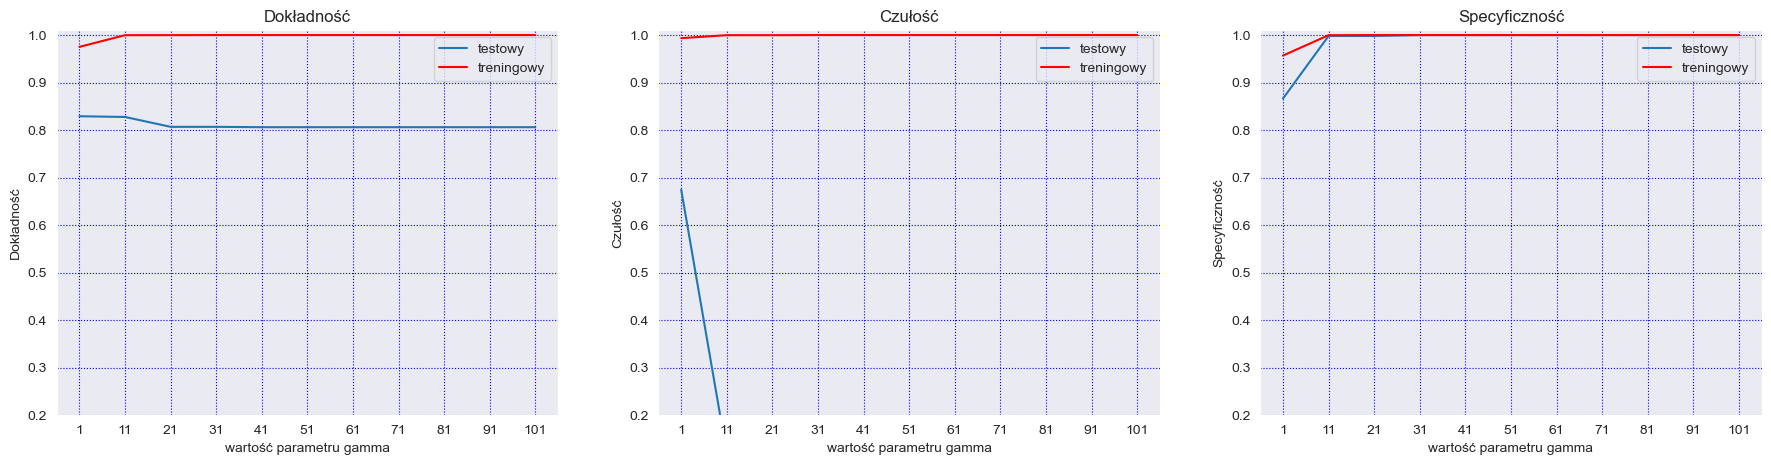

In [113]:
test_measures_svm = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_svm = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
gamma_range = range(1, 110, 10)

for gamma in gamma_range:
    model = svm.SVC(gamma=gamma, random_state=42)
    model.fit(X_train_svm, y_train_svm)

    # Ocena na zbiorze testowym
    y_pred_test_svm = model.predict(X_test_svm)
    measures_scores_test_svm = measures_score(y_test_svm, y_pred_test_svm, to_return=True, to_print=False)
    test_measures_svm['accuracy'].append(measures_scores_test_svm[0])
    test_measures_svm['recall'].append(measures_scores_test_svm[1])
    test_measures_svm['specificity'].append(measures_scores_test_svm[2])

    # Ocena na zbiorze treningowym
    y_pred_train_svm = model.predict(X_train_svm)
    measures_scores_train_svm = measures_score(y_train_svm, y_pred_train_svm, to_return=True, to_print=False)
    train_measures_svm['accuracy'].append(measures_scores_train_svm[0])
    train_measures_svm['recall'].append(measures_scores_train_svm[1])
    train_measures_svm['specificity'].append(measures_scores_train_svm[2])

fig, axs = plt.subplots(1, 3, figsize=(22, 5))
gamma_range_to_display = range(1, 110, 10)

subplot_measures(axs, 0, gamma_range, test_measures_svm['accuracy'], train_measures_svm['accuracy'], 'wartość parametru gamma', 'Dokładność', 'Dokładność', gamma_range_to_display)
subplot_measures(axs, 1, gamma_range, test_measures_svm['recall'], train_measures_svm['recall'], 'wartość parametru gamma', 'Czułość', 'Czułość', gamma_range_to_display)
subplot_measures(axs, 2, gamma_range, test_measures_svm['specificity'], train_measures_svm['specificity'], 'wartość parametru gamma', 'Specyficzność', 'Specyficzność', gamma_range_to_display)

Parametr gamma w zakresie 1-10

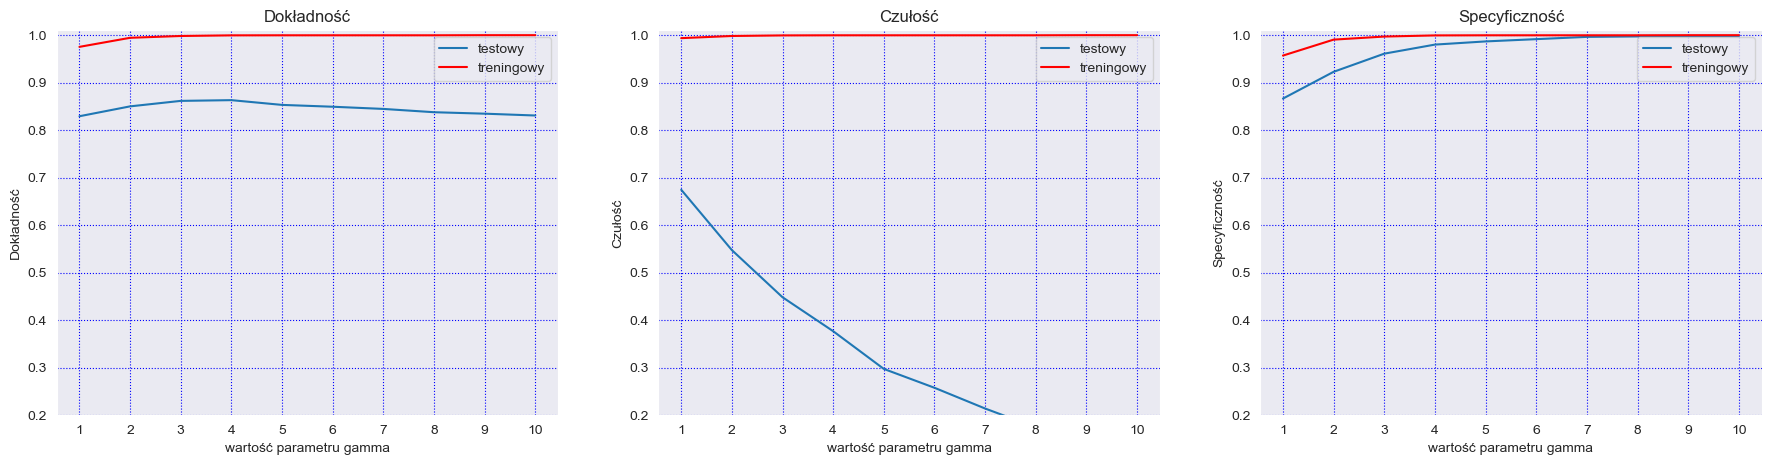

In [114]:
test_measures_svm = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_svm = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
gamma_range = range(1, 11, 1)

for gamma in gamma_range:
    model = svm.SVC(gamma=gamma, random_state=42)
    model.fit(X_train_svm, y_train_svm)

    # Ocena na zbiorze testowym
    y_pred_test_svm = model.predict(X_test_svm)
    measures_scores_test_svm = measures_score(y_test_svm, y_pred_test_svm, to_return=True, to_print=False)
    test_measures_svm['accuracy'].append(measures_scores_test_svm[0])
    test_measures_svm['recall'].append(measures_scores_test_svm[1])
    test_measures_svm['specificity'].append(measures_scores_test_svm[2])

    # Ocena na zbiorze treningowym
    y_pred_train_svm = model.predict(X_train_svm)
    measures_scores_train_svm = measures_score(y_train_svm, y_pred_train_svm, to_return=True, to_print=False)
    train_measures_svm['accuracy'].append(measures_scores_train_svm[0])
    train_measures_svm['recall'].append(measures_scores_train_svm[1])
    train_measures_svm['specificity'].append(measures_scores_train_svm[2])

fig, axs = plt.subplots(1, 3, figsize=(22, 5))
gamma_range_to_display = range(1, 11, 1)

subplot_measures(axs, 0, gamma_range, test_measures_svm['accuracy'], train_measures_svm['accuracy'], 'wartość parametru gamma', 'Dokładność', 'Dokładność', gamma_range_to_display)
subplot_measures(axs, 1, gamma_range, test_measures_svm['recall'], train_measures_svm['recall'], 'wartość parametru gamma', 'Czułość', 'Czułość', gamma_range_to_display)
subplot_measures(axs, 2, gamma_range, test_measures_svm['specificity'], train_measures_svm['specificity'], 'wartość parametru gamma', 'Specyficzność', 'Specyficzność', gamma_range_to_display)

Parametr gamma w zakresie 0.01-1

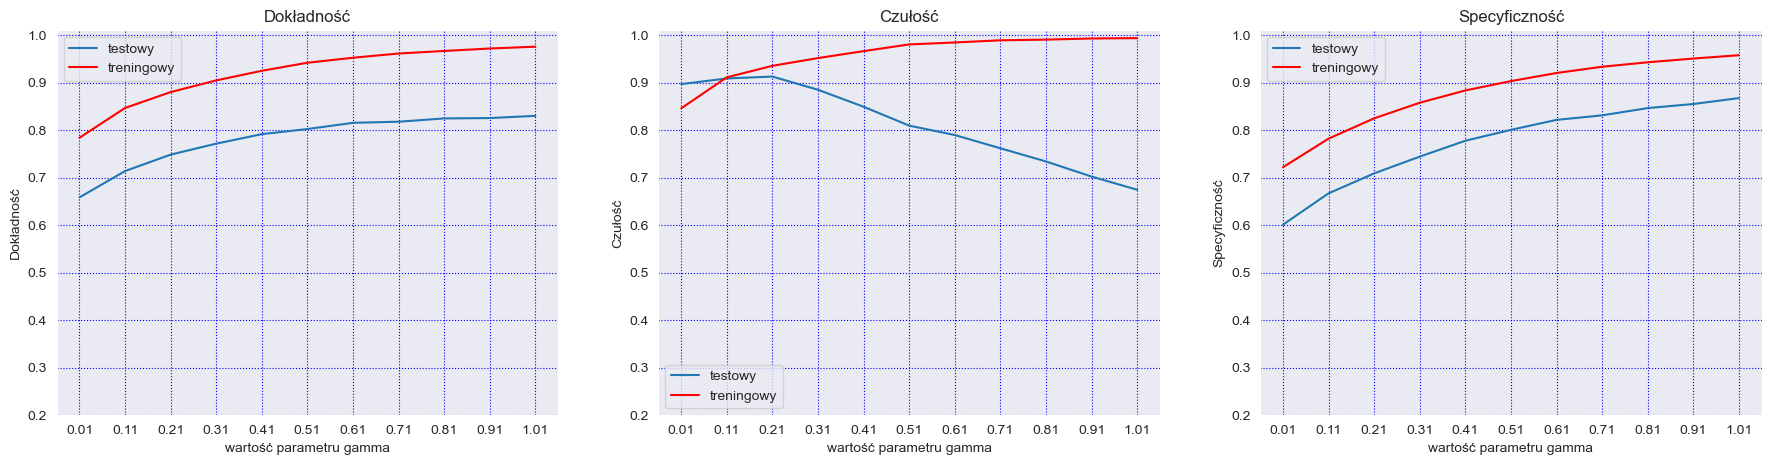

In [115]:
test_measures_svm = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_svm = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
gamma_range = np.arange(0.01, 1.1, 0.1)

for gamma in gamma_range:
    model = svm.SVC(gamma=gamma, random_state=42)
    model.fit(X_train_svm, y_train_svm)

    # Ocena na zbiorze testowym
    y_pred_test_svm = model.predict(X_test_svm)
    measures_scores_test_svm = measures_score(y_test_svm, y_pred_test_svm, to_return=True, to_print=False)
    test_measures_svm['accuracy'].append(measures_scores_test_svm[0])
    test_measures_svm['recall'].append(measures_scores_test_svm[1])
    test_measures_svm['specificity'].append(measures_scores_test_svm[2])

    # Ocena na zbiorze treningowym
    y_pred_train_svm = model.predict(X_train_svm)
    measures_scores_train_svm = measures_score(y_train_svm, y_pred_train_svm, to_return=True, to_print=False)
    train_measures_svm['accuracy'].append(measures_scores_train_svm[0])
    train_measures_svm['recall'].append(measures_scores_train_svm[1])
    train_measures_svm['specificity'].append(measures_scores_train_svm[2])

fig, axs = plt.subplots(1, 3, figsize=(22, 5))
gamma_range_to_display = np.arange(0.01, 1.1, 0.1)

subplot_measures(axs, 0, gamma_range, test_measures_svm['accuracy'], train_measures_svm['accuracy'], 'wartość parametru gamma', 'Dokładność', 'Dokładność', gamma_range_to_display)
subplot_measures(axs, 1, gamma_range, test_measures_svm['recall'], train_measures_svm['recall'], 'wartość parametru gamma', 'Czułość', 'Czułość', gamma_range_to_display)
subplot_measures(axs, 2, gamma_range, test_measures_svm['specificity'], train_measures_svm['specificity'], 'wartość parametru gamma', 'Specyficzność', 'Specyficzność', gamma_range_to_display)

In [116]:
C = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
gamma = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1, 'scale', 'auto']

In [117]:
param_grid = {
    'C': C,
    'gamma': gamma
}

In [118]:
svc = SVC(random_state=42)
grid_search = GridSearchCV(svc, param_grid, cv=5,  verbose=2, n_jobs=-1, scoring='recall')
grid_search.fit(X, y)
best_params = grid_search.best_params_  
print("Najlepsze parametry:", grid_search.best_params_)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Najlepsze parametry: {'C': 10, 'gamma': 0.05}


In [119]:
best_C = best_params['C']
best_gamma = best_params['gamma']

In [120]:
model = SVC(C=best_C, gamma=best_gamma, kernel='rbf', random_state=42)
model.fit(X_train_svm, y_train_svm)

y_pred_train = model.predict(X_train_svm)
measures_score(y_train_svm, y_pred_train, set_name='TRAIN')

y_pred_test = model.predict(X_test_svm)
measures_score(y_test_svm, y_pred_test, set_name='TEST')



TRAIN accuracy= 0.853      recall= 0.922        specificity= 0.785          
TEST  accuracy= 0.715      recall= 0.913        specificity= 0.667          


----------------------------- Drzewo Decyzyjne -------------------------


In [141]:
# dane do algorytmu Drzewa Decyzyjnego
X_train_dt = X_train.copy()
X_test_dt =  X_test.copy()
y_train_dt = y_train.copy()
y_test_dt = y_test.copy()

Model drzewa decyzyjnego z domyślnymi parametrami

In [142]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_dt, y_train_dt)
y_pred_train_dt = clf.predict(X_train_dt)
measures_score(y_train_dt, y_pred_train_dt, set_name='TRAIN')

y_pred_test_dt = clf.predict(X_test_dt)
measures_score(y_test_dt, y_pred_test_dt, set_name='TEST')

TRAIN accuracy= 1.0        recall= 1.0          specificity= 1.0            
TEST  accuracy= 0.828      recall= 0.694        specificity= 0.861          


Parametr max_depth

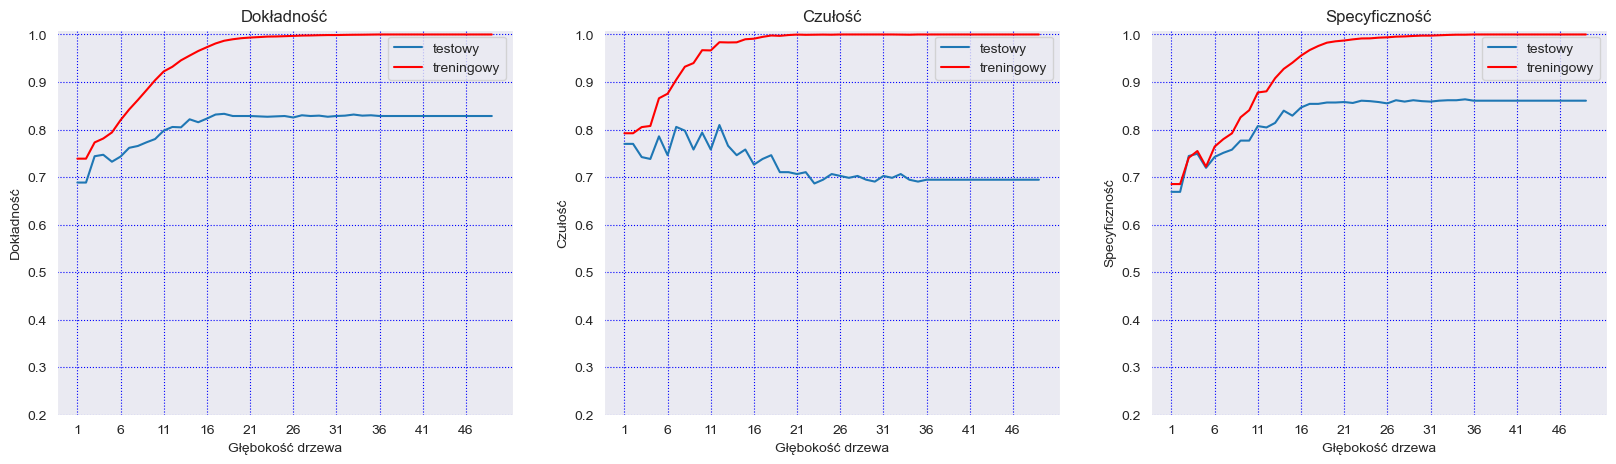

In [143]:
test_measures_dt = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_dt = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
tree_depth = range(1, 50)
tree_depth_to_display = range(1,50, 5)
for depth in tree_depth:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train_dt, y_train_dt)

    # Ocena na zbiorze testowym
    y_pred_test_dt = clf.predict(X_test_dt)
    measures_scores_test_dt = measures_score(y_test_dt, y_pred_test_dt, to_return=True, to_print=False)
    test_measures_dt['accuracy'].append(measures_scores_test_dt[0])
    test_measures_dt['recall'].append(measures_scores_test_dt[1])
    test_measures_dt['specificity'].append(measures_scores_test_dt[2])

    # Ocena na zbiorze treningowym
    y_pred_train_dt = clf.predict(X_train_dt)
    measures_scores_train_dt = measures_score(y_train_dt, y_pred_train_dt, to_return=True, to_print=False)
    train_measures_dt['accuracy'].append(measures_scores_train_dt[0])
    train_measures_dt['recall'].append(measures_scores_train_dt[1])
    train_measures_dt['specificity'].append(measures_scores_train_dt[2])

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
subplot_measures(axs, 0 , tree_depth,test_measures_dt['accuracy'], train_measures_dt['accuracy'], 'Głębokość drzewa','Dokładność', 'Dokładność',  tree_depth_to_display)
subplot_measures(axs, 1 , tree_depth,test_measures_dt['recall'], train_measures_dt['recall'], 'Głębokość drzewa','Czułość', 'Czułość',  tree_depth_to_display )
subplot_measures(axs, 2 , tree_depth,test_measures_dt['specificity'], train_measures_dt['specificity'], 'Głębokość drzewa','Specyficzność', 'Specyficzność',  tree_depth_to_display )

Parametr max_depth w zakresie 1-20

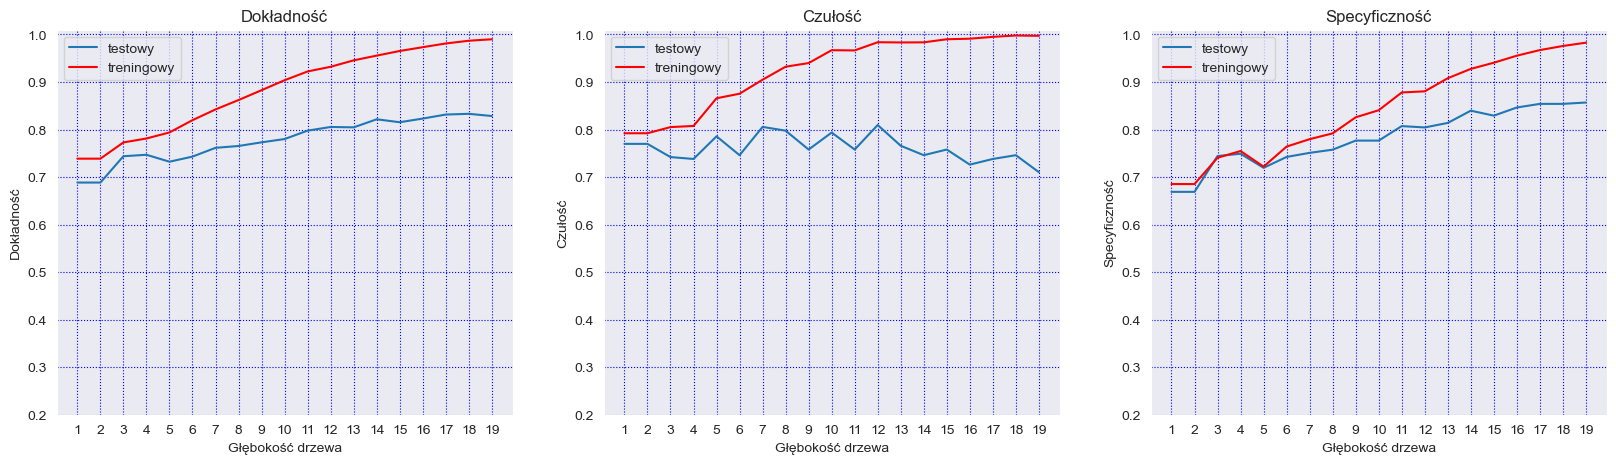

In [144]:
test_measures_dt = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_dt = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
tree_depth = range(1, 20)
tree_depth_to_display = range(1,20, 1)
for depth in tree_depth:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train_dt, y_train_dt)

    # Ocena na zbiorze testowym
    y_pred_test_dt = clf.predict(X_test_dt)
    measures_scores_test_dt = measures_score(y_test_dt, y_pred_test_dt, to_return=True, to_print=False)
    test_measures_dt['accuracy'].append(measures_scores_test_dt[0])
    test_measures_dt['recall'].append(measures_scores_test_dt[1])
    test_measures_dt['specificity'].append(measures_scores_test_dt[2])

    # Ocena na zbiorze treningowym
    y_pred_train_dt = clf.predict(X_train_dt)
    measures_scores_train_dt = measures_score(y_train_dt, y_pred_train_dt, to_return=True, to_print=False)
    train_measures_dt['accuracy'].append(measures_scores_train_dt[0])
    train_measures_dt['recall'].append(measures_scores_train_dt[1])
    train_measures_dt['specificity'].append(measures_scores_train_dt[2])

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
subplot_measures(axs, 0 , tree_depth,test_measures_dt['accuracy'], train_measures_dt['accuracy'], 'Głębokość drzewa','Dokładność', 'Dokładność',  tree_depth_to_display)
subplot_measures(axs, 1 , tree_depth,test_measures_dt['recall'], train_measures_dt['recall'], 'Głębokość drzewa','Czułość', 'Czułość',  tree_depth_to_display )
subplot_measures(axs, 2 , tree_depth,test_measures_dt['specificity'], train_measures_dt['specificity'], 'Głębokość drzewa','Specyficzność', 'Specyficzność',  tree_depth_to_display )

Parametr max_feature w zakresie 1-20

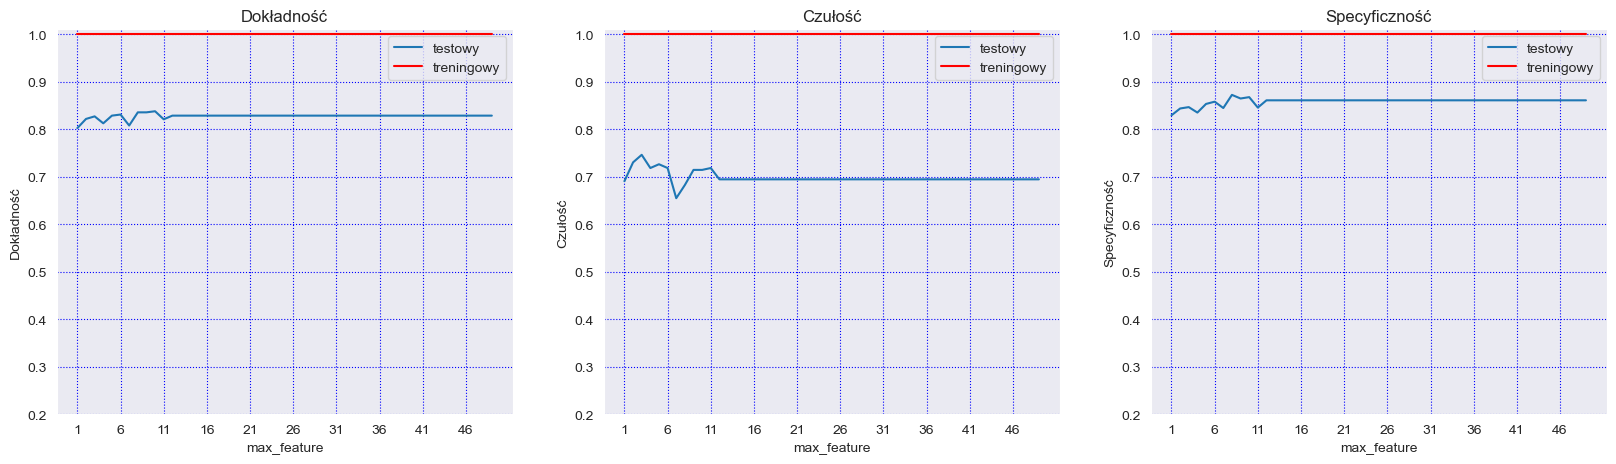

In [145]:
test_measures_dt = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_dt = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
max_feature = range(1, 50)
max_feature_to_display = range(1,50, 5)
for feature in max_feature:
    clf = DecisionTreeClassifier(max_features=feature ,random_state=42)
    clf.fit(X_train_dt, y_train_dt)

    # Ocena na zbiorze testowym
    y_pred_test_dt = clf.predict(X_test_dt)
    measures_scores_test_dt = measures_score(y_test_dt, y_pred_test_dt, to_return=True, to_print=False)
    test_measures_dt['accuracy'].append(measures_scores_test_dt[0])
    test_measures_dt['recall'].append(measures_scores_test_dt[1])
    test_measures_dt['specificity'].append(measures_scores_test_dt[2])

    # Ocena na zbiorze treningowym
    y_pred_train_dt = clf.predict(X_train_dt)
    measures_scores_train_dt = measures_score(y_train_dt, y_pred_train_dt, to_return=True, to_print=False)
    train_measures_dt['accuracy'].append(measures_scores_train_dt[0])
    train_measures_dt['recall'].append(measures_scores_train_dt[1])
    train_measures_dt['specificity'].append(measures_scores_train_dt[2])

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
subplot_measures(axs, 0 , max_feature,test_measures_dt['accuracy'], train_measures_dt['accuracy'], 'max_feature','Dokładność', 'Dokładność',  max_feature_to_display)
subplot_measures(axs, 1 , max_feature,test_measures_dt['recall'], train_measures_dt['recall'], 'max_feature','Czułość', 'Czułość',  max_feature_to_display )
subplot_measures(axs, 2 , max_feature,test_measures_dt['specificity'], train_measures_dt['specificity'], 'max_feature','Specyficzność', 'Specyficzność',  max_feature_to_display )

Parametr max_feature w zakresie 1 - 12

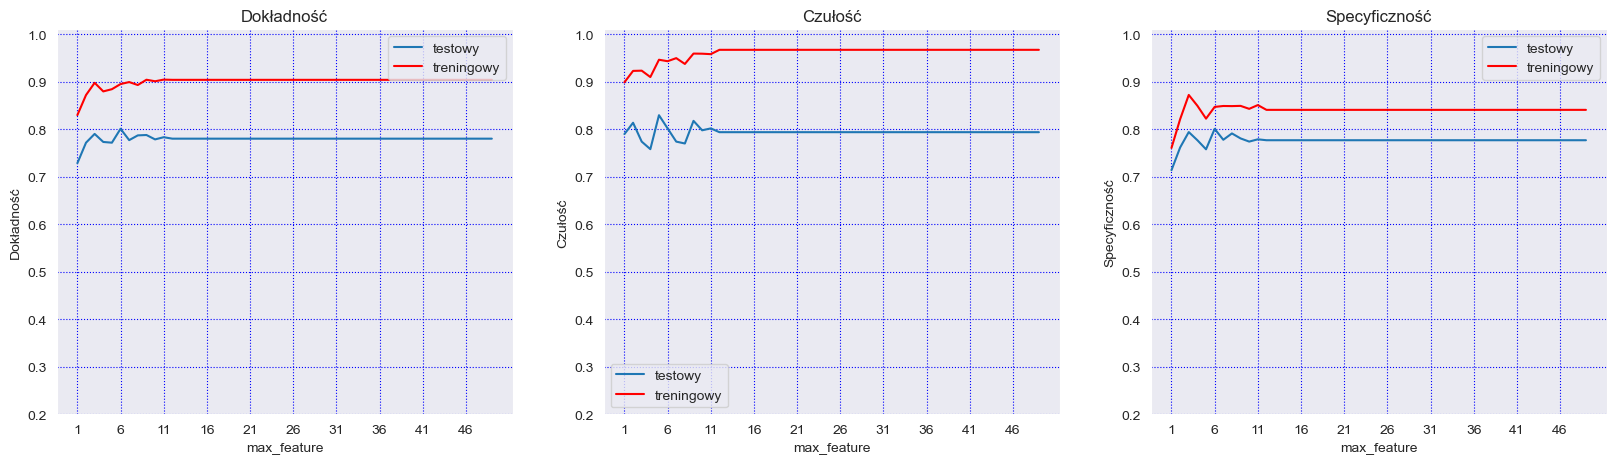

In [146]:
test_measures_dt = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_dt = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
max_feature = np.arange(1, 12)
max_feature_to_display = range(1,12, 1)
for feature in max_feature:
    clf = DecisionTreeClassifier(max_features=feature, random_state=42)
    clf.fit(X_train_dt, y_train_dt)

    # Ocena na zbiorze testowym
    y_pred_test_dt = clf.predict(X_test_dt)
    measures_scores_test_dt = measures_score(y_test_dt, y_pred_test_dt, to_return=True, to_print=False)
    test_measures_dt['accuracy'].append(measures_scores_test_dt[0])
    test_measures_dt['recall'].append(measures_scores_test_dt[1])
    test_measures_dt['specificity'].append(measures_scores_test_dt[2])

    # Ocena na zbiorze treningowym
    y_pred_train_dt = clf.predict(X_train_dt)
    measures_scores_train_dt = measures_score(y_train_dt, y_pred_train_dt, to_return=True, to_print=False)
    train_measures_dt['accuracy'].append(measures_scores_train_dt[0])
    train_measures_dt['recall'].append(measures_scores_train_dt[1])
    train_measures_dt['specificity'].append(measures_scores_train_dt[2])

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
subplot_measures(axs, 0 , max_feature,test_measures_dt['accuracy'], train_measures_dt['accuracy'], 'max_features','Dokładność', 'Dokładność',  max_feature_to_display)
subplot_measures(axs, 1 , max_feature,test_measures_dt['recall'], train_measures_dt['recall'], 'max_features','Czułość', 'Czułość',  max_feature_to_display )
subplot_measures(axs, 2 , max_feature,test_measures_dt['specificity'], train_measures_dt['specificity'], 'max_features','Specyficzność', 'Specyficzność',  max_feature_to_display )

Parametr max_features 1-50 i max_depth=10

In [147]:
test_measures_dt = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_dt = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
max_feature = range(1, 50)
max_feature_to_display = range(1,50, 5)
for feature in max_feature:
    clf = DecisionTreeClassifier(max_features=feature, max_depth = 10 ,random_state=42)
    clf.fit(X_train_dt, y_train_dt)

    # Ocena na zbiorze testowym
    y_pred_test_dt = clf.predict(X_test_dt)
    measures_scores_test_dt = measures_score(y_test_dt, y_pred_test_dt, to_return=True, to_print=False)
    test_measures_dt['accuracy'].append(measures_scores_test_dt[0])
    test_measures_dt['recall'].append(measures_scores_test_dt[1])
    test_measures_dt['specificity'].append(measures_scores_test_dt[2])

    # Ocena na zbiorze treningowym
    y_pred_train_dt = clf.predict(X_train_dt)
    measures_scores_train_dt = measures_score(y_train_dt, y_pred_train_dt, to_return=True, to_print=False)
    train_measures_dt['accuracy'].append(measures_scores_train_dt[0])
    train_measures_dt['recall'].append(measures_scores_train_dt[1])
    train_measures_dt['specificity'].append(measures_scores_train_dt[2])

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
subplot_measures(axs, 0 , max_feature,test_measures_dt['accuracy'], train_measures_dt['accuracy'], 'max_feature','Dokładność', 'Dokładność',  max_feature_to_display)
subplot_measures(axs, 1 , max_feature,test_measures_dt['recall'], train_measures_dt['recall'], 'max_feature','Czułość', 'Czułość',  max_feature_to_display )
subplot_measures(axs, 2 , max_feature,test_measures_dt['specificity'], train_measures_dt['specificity'], 'max_feature','Specyficzność', 'Specyficzność',  max_feature_to_display )

Metoda Grid Search dla drzewa decyzyjnego

In [152]:
best_max_depth = None
best_max_features = None

In [156]:
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 20]
max_features = [1, 2, 3, 4, 5,6, 7, 8, 9, 10, 'auto', 'sqrt', 'log2']

Fitting 5 folds for each of 65 candidates, totalling 325 fits
Najlepsze parametry: {'max_depth': 4, 'max_features': 4}
Najlepsza dokładność zbalansowana: 0.32917585784313724


In [159]:
param_grid = {
    'max_depth': max_depth,
    'max_features': max_features
}

Fitting 5 folds for each of 65 candidates, totalling 325 fits
Najlepsze parametry: {'max_depth': 4, 'max_features': 4}
Najlepsza dokładność zbalansowana: 0.32917585784313724


In [160]:
clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=3, verbose=2, n_jobs=-1, scoring='recall')
grid_search.fit(X, y)
best_params = grid_search.best_params_
print(f"Najlepsze parametry:", grid_search.best_params_)
print("Najlepsza dokładność zbalansowana:", grid_search.best_score_)

In [161]:
best_max_depth =  best_params['max_depth']
best_max_features = best_params['max_features']

TRAIN accuracy= 0.726      recall= 0.713        specificity= 0.738          
TEST  accuracy= 0.718      recall= 0.687        specificity= 0.726          


In [133]:
clf = DecisionTreeClassifier(max_depth=best_max_depth,max_features=best_max_features, random_state=42)
clf.fit(X_train_dt, y_train_dt)

y_pred_train_dt = clf.predict(X_train_dt)
measures_score(y_train_dt, y_pred_train_dt, set_name='TRAIN')

y_pred_test_dt = clf.predict(X_test_dt)
measures_score(y_test_dt, y_pred_test_dt, set_name='TEST')

TRAIN accuracy= 0.959      recall= 0.991        specificity= 0.927          
TEST  accuracy= 0.806      recall= 0.794        specificity= 0.809          


----------------------------- METODA KNN -------------------------

In [167]:
X_train_knn = X_train.copy()
X_test_knn =  X_test.copy()
y_train_knn = y_train.copy()
y_test_knn = y_test.copy()

In [168]:
X_train_knn = standardize_data(X_train_knn)
X_test_knn = standardize_data(X_test_knn)

Fitting 3 folds for each of 65 candidates, totalling 195 fits
Najlepsze parametry: {'max_depth': 5, 'max_features': 4}
Najlepsza dokładność zbalansowana: 0.35188437816441126


Model KNN dla domyślnych parametrów

In [170]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_knn, y_train_knn)

y_pred_train_knn = knn_model.predict(X_train_knn)
measures_score(y_train_knn, y_pred_train_knn, set_name='TRAIN')

y_pred_test_knn = knn_model.predict(X_test_knn)
measures_score(y_test_knn, y_pred_test_knn, set_name='TEST')

TRAIN accuracy= 0.777      recall= 0.868        specificity= 0.686          
TEST  accuracy= 0.682      recall= 0.794        specificity= 0.655          


Parametr n_neighbors w zakresie 1-50 i weights='uniform'

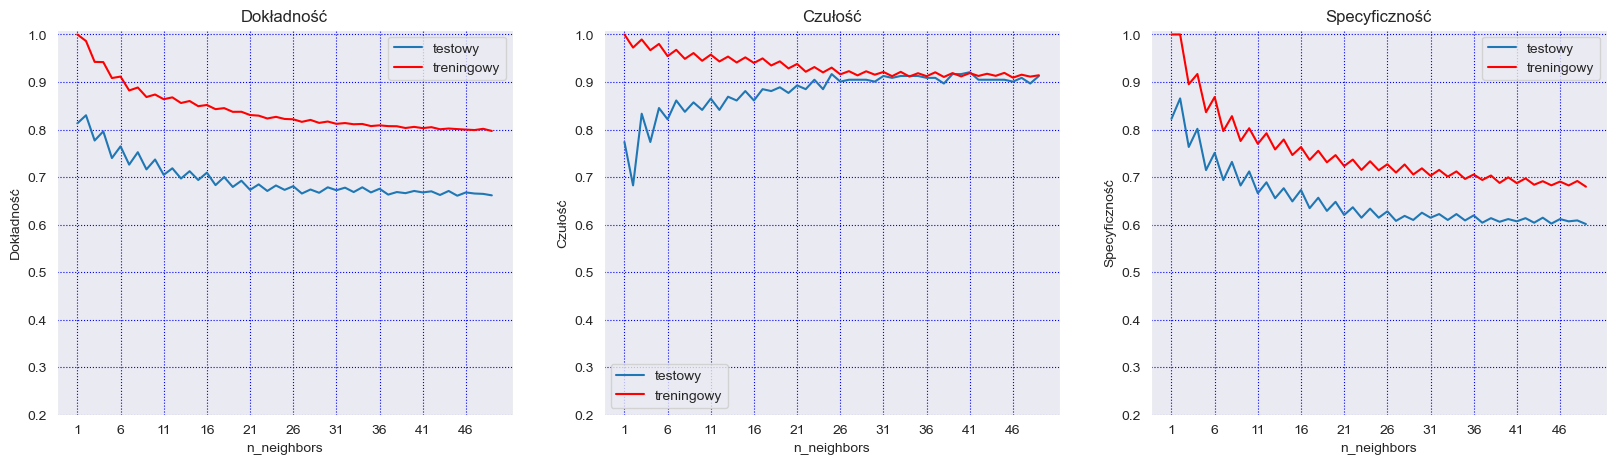

In [137]:
test_measures_knn = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_knn = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
neighbours = np.arange(1, 50)
neighbours_to_display = range(1,50, 5)
for neighbour in neighbours:
    knn_model = KNeighborsClassifier(n_neighbors=neighbour, weights='uniform')
    knn_model.fit(X_train_knn, y_train_knn)

    # Ocena na zbiorze testowym
    y_pred_test_knn = knn_model.predict(X_test_knn)
    measures_scores_test_knn = measures_score(y_test_knn, y_pred_test_knn, to_return=True, to_print=False)
    test_measures_knn['accuracy'].append(measures_scores_test_knn[0])
    test_measures_knn['recall'].append(measures_scores_test_knn[1])
    test_measures_knn['specificity'].append(measures_scores_test_knn[2])

    # Ocena na zbiorze treningowym
    y_pred_train_knn = knn_model.predict(X_train_knn)
    measures_scores_train_knn = measures_score(y_train_knn, y_pred_train_knn, to_return=True, to_print=False)
    train_measures_knn['accuracy'].append(measures_scores_train_knn[0])
    train_measures_knn['recall'].append(measures_scores_train_knn[1])
    train_measures_knn['specificity'].append(measures_scores_train_knn[2])

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
subplot_measures(axs, 0 , neighbours,test_measures_knn['accuracy'], train_measures_knn['accuracy'], 'n_neighbors','Dokładność', 'Dokładność',  neighbours_to_display)
subplot_measures(axs, 1 , neighbours,test_measures_knn['recall'], train_measures_knn['recall'], 'n_neighbors','Czułość', 'Czułość',  neighbours_to_display )
subplot_measures(axs, 2 , neighbours,test_measures_knn['specificity'], train_measures_knn['specificity'], 'n_neighbors','Specyficzność', 'Specyficzność',  neighbours_to_display )

Parametr n_neighbors w zakresie 1-20 i weights='uniform'

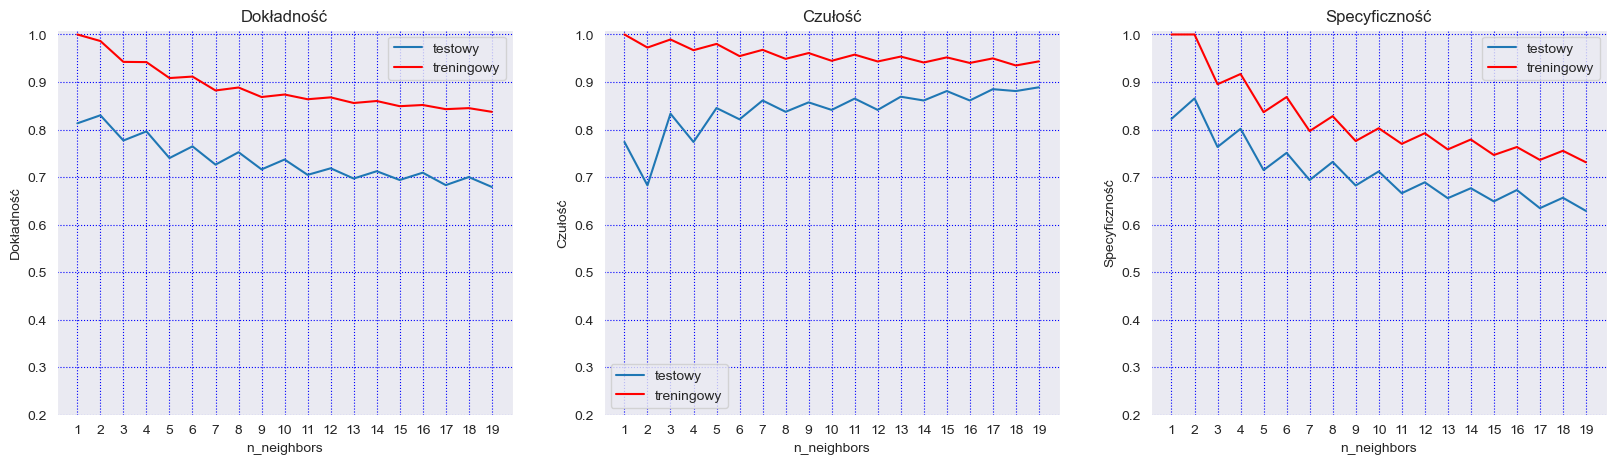

In [138]:
test_measures_knn = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_knn = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
neighbours = np.arange(1, 20)
neighbours_to_display = range(1,20, 1)
for neighbour in neighbours:
    knn_model = KNeighborsClassifier(n_neighbors=neighbour, weights='uniform')
    knn_model.fit(X_train_knn, y_train_knn)

    # Ocena na zbiorze testowym
    y_pred_test_knn = knn_model.predict(X_test_knn)
    measures_scores_test_knn = measures_score(y_test_knn, y_pred_test_knn, to_return=True, to_print=False)
    test_measures_knn['accuracy'].append(measures_scores_test_knn[0])
    test_measures_knn['recall'].append(measures_scores_test_knn[1])
    test_measures_knn['specificity'].append(measures_scores_test_knn[2])

    # Ocena na zbiorze treningowym
    y_pred_train_knn = knn_model.predict(X_train_knn)
    measures_scores_train_knn = measures_score(y_train_knn, y_pred_train_knn, to_return=True, to_print=False)
    train_measures_knn['accuracy'].append(measures_scores_train_knn[0])
    train_measures_knn['recall'].append(measures_scores_train_knn[1])
    train_measures_knn['specificity'].append(measures_scores_train_knn[2])

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
subplot_measures(axs, 0 , neighbours,test_measures_knn['accuracy'], train_measures_knn['accuracy'], 'n_neighbors','Dokładność', 'Dokładność',  neighbours_to_display)
subplot_measures(axs, 1 , neighbours,test_measures_knn['recall'], train_measures_knn['recall'], 'n_neighbors','Czułość', 'Czułość',  neighbours_to_display )
subplot_measures(axs, 2 , neighbours,test_measures_knn['specificity'], train_measures_knn['specificity'], 'n_neighbors','Specyficzność', 'Specyficzność',  neighbours_to_display )

Parametr n_neighbors w zakresie 1-50 i weights='distance'

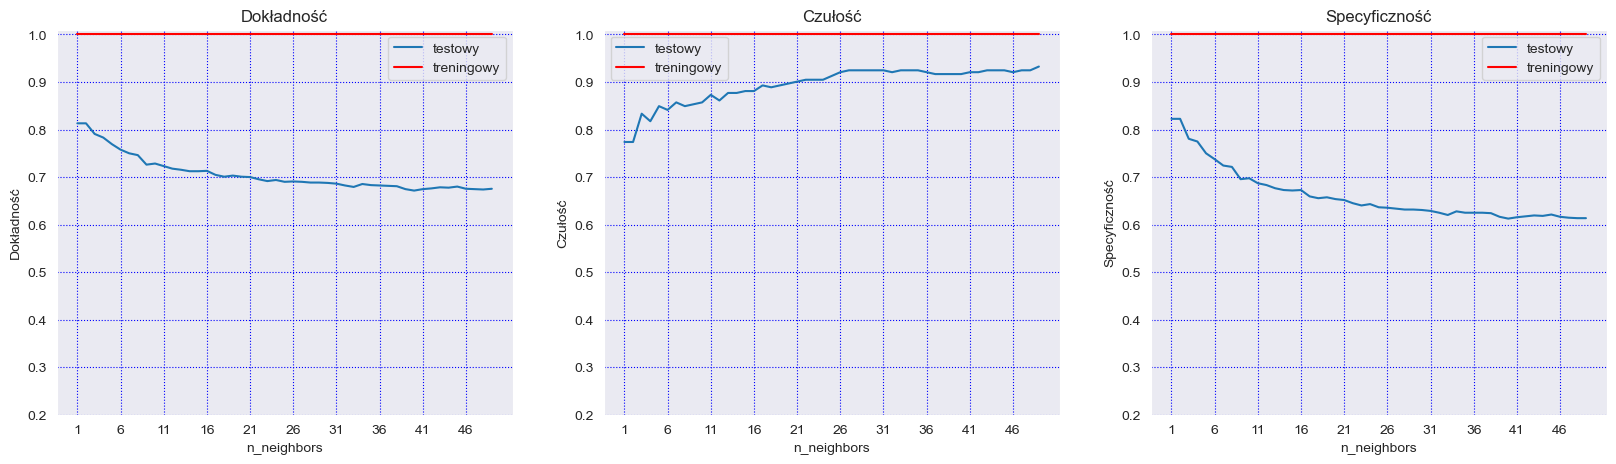

In [139]:
test_measures_knn = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
train_measures_knn = {'accuracy': [], 'recall': [], 'specificity': [], 'precision': []}
neighbours = np.arange(1, 50)
neighbours_to_display = range(1,50, 5)
for neighbour in neighbours:
    knn_model = KNeighborsClassifier(n_neighbors=neighbour, weights='distance', metric='euclidean')
    knn_model.fit(X_train_knn, y_train_knn)

    # Ocena na zbiorze testowym
    y_pred_test_knn = knn_model.predict(X_test_knn)
    measures_scores_test_knn = measures_score(y_test_knn, y_pred_test_knn, to_return=True, to_print=False)
    test_measures_knn['accuracy'].append(measures_scores_test_knn[0])
    test_measures_knn['recall'].append(measures_scores_test_knn[1])
    test_measures_knn['specificity'].append(measures_scores_test_knn[2])

    # Ocena na zbiorze treningowym
    y_pred_train_knn = knn_model.predict(X_train_knn)
    measures_scores_train_knn = measures_score(y_train_knn, y_pred_train_knn, to_return=True, to_print=False)
    train_measures_knn['accuracy'].append(measures_scores_train_knn[0])
    train_measures_knn['recall'].append(measures_scores_train_knn[1])
    train_measures_knn['specificity'].append(measures_scores_train_knn[2])

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
subplot_measures(axs, 0 , neighbours,test_measures_knn['accuracy'], train_measures_knn['accuracy'], 'n_neighbors','Dokładność', 'Dokładność',  neighbours_to_display)
subplot_measures(axs, 1 , neighbours,test_measures_knn['recall'], train_measures_knn['recall'], 'n_neighbors','Czułość', 'Czułość',  neighbours_to_display )
subplot_measures(axs, 2 , neighbours,test_measures_knn['specificity'], train_measures_knn['specificity'], 'n_neighbors','Specyficzność', 'Specyficzność',  neighbours_to_display )

Model KNN po zdefiniowaniu najlepszych parametrów

In [140]:
knn_model = KNeighborsClassifier(n_neighbors=6, weights='uniform')
knn_model.fit(X_train_knn, y_train_knn)

y_pred_train_knn = knn_model.predict(X_train_knn)
measures_score(y_train_knn, y_pred_train_knn, set_name='TRAIN')

y_pred_test_knn = knn_model.predict(X_test_knn)
measures_score(y_test_knn, y_pred_test_knn, set_name='TEST')

TRAIN accuracy= 0.911      recall= 0.954        specificity= 0.868          
TEST  accuracy= 0.765      recall= 0.821        specificity= 0.751          
